<p align="center"><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true"></p><h1><font color='0B5345'> <center>

 </center></font></h1>
<h2><font color='0B5345'> <center>
Bioseñales y Sistemas</center></font></h2>
<font  face="Courier New" size="3">

 </center></font></h1>
<h2><font color='0B5345'> <center>
Práctica 3 (Parte 1): Análisis estadístico en señales ECG </center></font></h2>
<font  face="Courier New" size="2">

 </center></font></h1>
<h2><font color='0B5345'> <center>
Isabella Vásquez García </center></font></h2>
<font  face="Courier New" size="1">

 </center></font></h1>
<h2><font color='0B5345'> <center>
C.C. 1000.438.341 </center></font></h2>
<font  face="Courier New" size="1">

 </center></font></h1>
<h2><font color='0B5345'> <center>
Marie Anne Johanna Bernal Diaz </center></font></h2>
<font  face="Courier New" size="1">

 </center></font></h1>
<h2><font color='0B5345'> <center>
C.C. 1003.894.043 </center></font></h2>
<font  face="Courier New" size="1">

<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia - Bioingeniería</font></b> </center></p3>

Inicialmemte, es necesario importar las librerías a utilizar:

In [113]:
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from scipy import stats

Posteriormente, se carga el archivo que nos entregará las señales a las que se les realizará el análisis estadístico

In [114]:
from google.colab import files
# Se carga el archivo al espacio de trabajo de Colab
load = files.upload()
# Debido a que el archivo tiene una extensión .mat, es necesario utilizar la función scipy.io.loadmat
data = scipy.io.loadmat('/content/signals.mat')
# Creamos una copia de los datos para evitar modificar el archivo original
copy_data = data.copy()
# Visualizamos
print(copy_data)

Saving signals.mat to signals (2).mat
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Apr 20 15:20:29 2015', '__version__': '1.0', '__globals__': [], 'Fs': array([[1024]], dtype=uint16), 'ECG_asRecording': array([[3904.31689453, 3939.203125  , 3976.00683594, ..., 4366.41064453,
        4365.31103516, 4370.91796875]]), 'ECG_filtered': array([[ 8.87103896e-03,  5.62737497e+01,  8.57077127e+01, ...,
        -1.20952610e+02, -1.31734356e+02, -1.32898021e+02]]), 'EMG_filtered1': array([[ 17.65905117,  19.41391578,  18.89666666, ..., 242.49414224,
        220.4135886 , 151.5810508 ]]), 'EMG_filtered2': array([[  21.1780547 ,  -79.82418538, -133.65960989, ..., -384.58994036,
        -539.9349533 , -772.65519631]]), 'EMG_asRecording1': array([[ 908.07531738,  903.17706299,  896.62982178, ..., 1433.91882324,
        1416.109375  , 1352.75012207]]), 'EMG_asRecording2': array([[-3109.97558594, -3231.01391602, -3302.34960938, ...,
        -3791.24267578, -3924.6550293 , -4

Como podemos ver, los datos se encuentran en un diccionario, por lo que vamos extraer las claves del diccionario con la función .keys() para visualizar mejor que datos tenemos

In [115]:
copy_data.keys()
ECG = copy_data['ECG_asRecording']
ECG_filtrado =  copy_data['ECG_filtered']

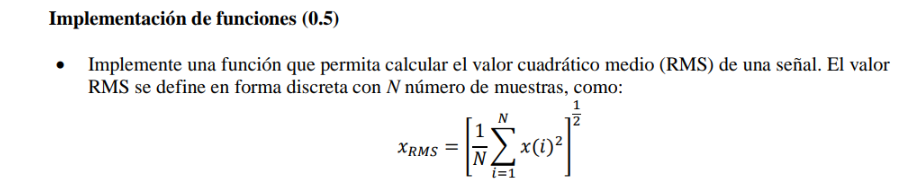

In [116]:
# La función del RMS se compone de una sumatoria de cada muestra. A este resultado se le halla el promedio y se le saca raiz cuadrada
def RMS(s):
  rms = np.sqrt(np.mean(s**2))
  return rms

In [117]:
# Prueba de como trabaja la función que se creó anteriormente
señal=np.array([2,4,5,6,7])
print(RMS(señal))

5.0990195135927845


#**Análisis Estadístico de ECG**

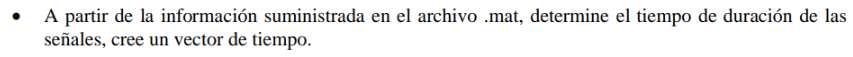

En el enunciado se menciona que la tasa de muestreo fué de 1024 Hz, por lo que el periodo de muestreo es 1/1024 segundos.

In [118]:
F = 1024 #Hz
T = 1/F
# Como no podemos asumir que la señal cruda y la filtrada tiene el mismo vector de tiempo, se crea uno por cada señal.
ECG_t= np.arange(0,ECG.size*T,T)
print(ECG_t)
ECG_filtrado_t = np.arange(0,ECG_filtrado.size*T,T)
print(ECG_filtrado_t)

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]
[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]


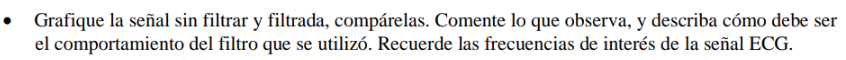

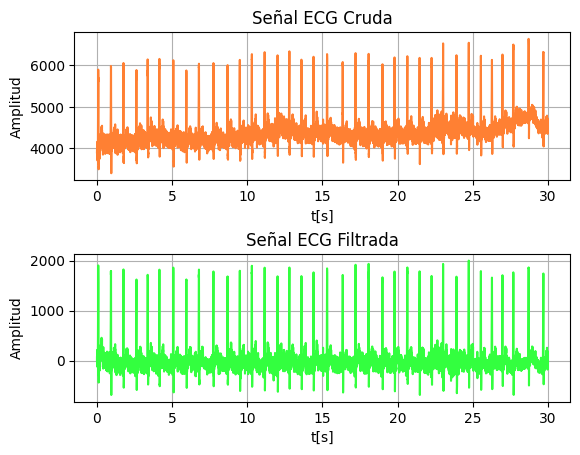

In [119]:
ECG_1D = ECG.flatten()
ECG_filtrado_1D = ECG_filtrado.flatten()

plt.subplots_adjust(hspace=0.5, wspace=0.6)

plt.subplot(2,1,1)
plt.plot(ECG_t,ECG_1D, "#ff8033")
plt.title('Señal ECG Cruda')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ECG_filtrado_t,ECG_filtrado_1D,"#33ff3f")
plt.title('Señal ECG Filtrada')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

Debido a que el periodo de muestreo es de 1/1024, es decir aproximadamente 0,97ms, cada vez que se cumpla este tiempo se toma una muestra. Gráficamente podemos evidenciar que **la señal filtrada respecto a la cruda, no presenta tendencias lineales por lo posiblemente se utilizó un filtro para eliminar esto**. También evidenciamos que la amplitud de las señales es de 2000, por lo que esta propiedad no cambia en las dos señales y puede deberse a que **el filtro utilizado es probablemente de ganacia 1**. Finalmente, también evidenciamos que la señal cruda presentaba un offset en 4000 mientras que en la señal filtrada se eliminó el mismo.

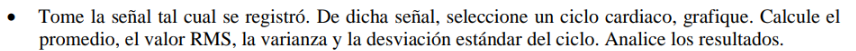

Inicialmente, vamos a analizar la distancia entre picos. Para eso, graficamos las señales entre 0 y 200 milisegundos, con el fin de identificar si en este rango de tiempo tenemos un máximo de cada señal

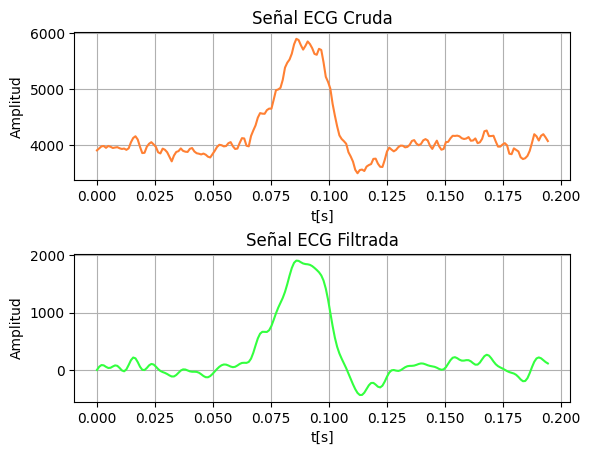

In [120]:
plt.subplots_adjust(hspace=0.5, wspace=0.6)

plt.subplot(2,1,1)
plt.plot(ECG_t[0:200],ECG_1D[0:200], "#ff8033")
plt.title('Señal ECG Cruda')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ECG_filtrado_t[0:200],ECG_filtrado_1D[0:200],"#33ff3f")
plt.title('Señal ECG Filtrada')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

Con lo anterior, **podemos identificar una señal parecida a la pqrst característica del ECG** por lo que utilizaremos lo hallado anteriormente como un ciclo de la señal cruda y filtrada.

**Cabe aclarar que estas señales no representan exactamente un ciclo de cada señal. Solo nos basamos en la evidencia gráfica**

In [121]:
ciclo_ECG_1 = ECG_1D[0:200]

promedio_ciclo1 = np.mean(ciclo_ECG_1)
print('El promedio de un ciclo de la señal cruda de ECG es: ',promedio_ciclo1)
rms_ciclo1 = RMS(ciclo_ECG_1)
print('El RMS de un ciclo de la señal cruda de ECG es:', rms_ciclo1)
varianza_ciclo1 = np.var(ciclo_ECG_1)
print('La varianza de un ciclo de la señal cruda de ECG es:', varianza_ciclo1 )
desviacion_estandar_ciclo_1 = np.std(ciclo_ECG_1)
print('La desviación estandar de un ciclo de la señal cruda de ECG es:', desviacion_estandar_ciclo_1 )

El promedio de un ciclo de la señal cruda de ECG es:  4187.809591064453
El RMS de un ciclo de la señal cruda de ECG es: 4224.161147725184
La varianza de un ciclo de la señal cruda de ECG es: 305788.2309395187
La desviación estandar de un ciclo de la señal cruda de ECG es: 552.9812211454552


Debido a los valores de desviación estándart tan altos, se puede decir que los datos se encuentran muy dispersos, es decir, alejados de la media. Lo anterior también se relaciona con la varianza, ya que al ser un valor tan alto para la señal cruda, se entiende que la diferencia de cada dato con la media de la señal es muy alta. Finalmente, como el error cuadrático también es muy alto existe una diferencia grande entre los valores de la señal cruda

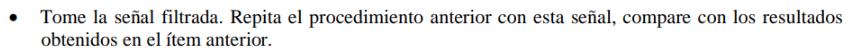

In [122]:
ciclo_ECG_filtrado_1 = ECG_filtrado_1D[0:200]
promedio_ciclo_filtrado_1 = np.mean(ciclo_ECG_filtrado_1)
print('El promedio de un ciclo de la señal filtrada de ECG es: ',promedio_ciclo_filtrado_1)
rms_ciclo_filtrado1 = RMS(ciclo_ECG_filtrado_1)
print('El RMS de un ciclo de la señal filtrada de ECG es:', rms_ciclo_filtrado1)
varianza_ciclo_filtrado1 = np.var(ciclo_ECG_filtrado_1)
print('La varianza de un ciclo de la señal filtrada de ECG es:', varianza_ciclo_filtrado1 )
desviacion_estandar_ciclo_filtrado1 = np.std(ciclo_ECG_filtrado_1)
print('La desviación estandar de un ciclo de la señal filtrada de ECG es:', desviacion_estandar_ciclo_filtrado1 )


El promedio de un ciclo de la señal filtrada de ECG es:  251.34778813179722
El RMS de un ciclo de la señal filtrada de ECG es: 606.4478112310361
La varianza de un ciclo de la señal filtrada de ECG es: 304603.2371481676
La desviación estandar de un ciclo de la señal filtrada de ECG es: 551.9087217540302


Respecto a la señal cruda, se puede decir que el promedio disminuyó considerablemente en la señal filtrada, principalmente por el offset que se tiene. También, la varianza y la desviación estándar siguen siendo muy altas y sus diferencias respecto a la señal cruda no es significativa por lo que los valores siguen igual de dispersos.

Respecto al RMS bajó un poco respecto a la señal cruda, sin embargo, sigue siendo un valor alto que me indica una diferencia entre el conjunto de valores.

**Finalmente, se puede concluir que entre la señal cruda y la señal filtrada no existen diferencias estadísticas significativas por lo que el proceso de filtrado no afectó tales características**.

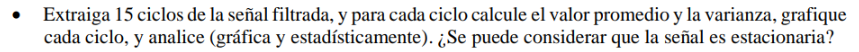

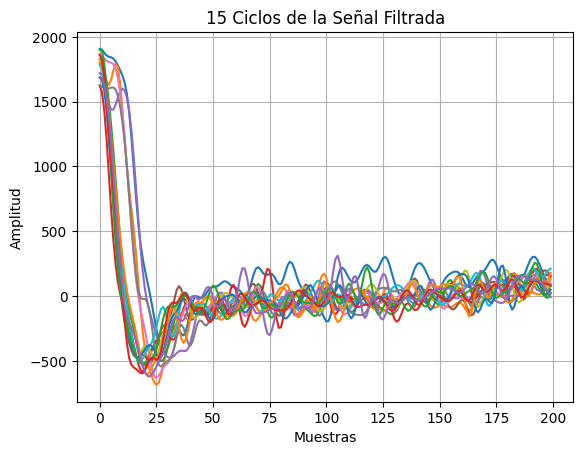

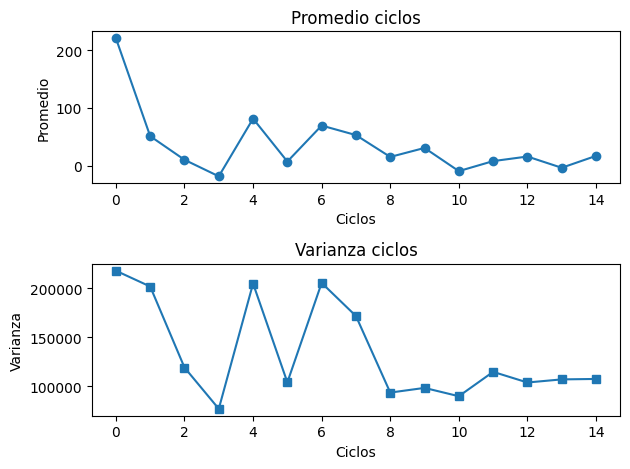

In [123]:
peaks,_= find_peaks(ECG_filtrado_1D, distance= F/2)
ciclos = [ECG_filtrado_1D[peaks[i]:peaks[i] + 200] for i in range(min(15, len(peaks)))]

plt.figure()
for ciclo in ciclos:
  plt.plot(ciclo)

plt.title('15 Ciclos de la Señal Filtrada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

promedio_ciclos = [np.mean(ciclo) for ciclo in ciclos]
varianza_ciclos = [np.var(ciclo) for ciclo in ciclos]


plt.figure()
plt.subplot(2, 1, 1)
plt.plot(promedio_ciclos, 'o-')
plt.title('Promedio ciclos')
plt.xlabel('Ciclos')
plt.ylabel('Promedio')

plt.subplot(2, 1, 2)
plt.plot(varianza_ciclos, 's-')
plt.title('Varianza ciclos')
plt.xlabel('Ciclos')
plt.ylabel('Varianza')
plt.tight_layout()
plt.show()


**La varianza y el promedio no varian significativamente apartir del ciclo 8 hasta el ciclo 14, por lo que podemos asumir su estacionariedad en esa zona**.

 Sin embargo **al analizar la totalidad del los ciclos, podemos notar que los datos no son estacionarios, ya que el promedio y la varianza no se mantienen constantes entre ciclos**.

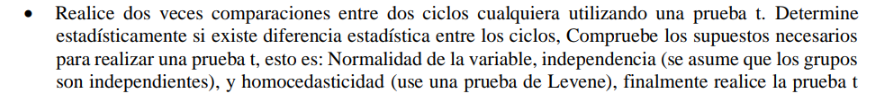

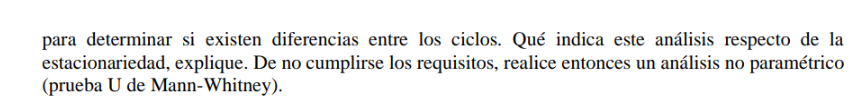

Para realizar el análsis inferencial solicitado, iniciaremos escogiendo dos ciclos de la señal filtrada ya que se sabe que en dos ciclos de una señal ECG se pueden encontrar diferencias significativas que aporten a la detección de una patología entre otros. Teniendo en cuenta que para ítems anteriores ya se había definido cierto rango de la señal filtrada de un ciclo, a continuación solo se muestran gráficamente los dos ciclos iniciales a analizar

### **Análisis inferencial entre los ciclos 1 y 2 que representa aproximadamente el primer y último ciclo de la señal**

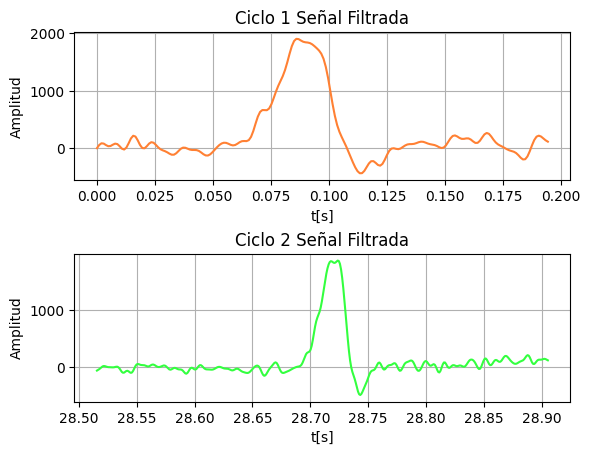

In [124]:
ciclo_ECG_filtrado_1 = ECG_filtrado_1D[0:200]
ciclo_ECG_filtrado_2 = ECG_filtrado_1D[29200:29600]

plt.subplots_adjust(hspace=0.5, wspace=0.6)

plt.subplot(2,1,1)
plt.plot(ECG_filtrado_t[0:200],ciclo_ECG_filtrado_1, "#ff8033")
plt.title('Ciclo 1 Señal Filtrada')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ECG_filtrado_t[29200:29600],ciclo_ECG_filtrado_2,"#33ff3f")
plt.title('Ciclo 2 Señal Filtrada')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

Después de tener los dos ciclos iniciales, para poder hacer un análisis inferencial a través de la prueba paramétrica T, se debe cumplir los supuestos de normalidad y de homocedasticidas ya que se indicó que las señales son independientes:

Para revisar si los datos provienen de una distribución normal se realiza la prueba de Shapiro, la cual es ideal cuando contamos con pocos datos como en este caso que solo estamos tomando un ciclco del ECG dado. Las hipótesis para esta prueba son:

**Hipótesis Nula (H0)**: los datos siguen una distribución normal

**Hipótesis Alternativa (Ha)**:los datos no siguen una distribución normal

Porteriormente, para poder determinar si se cumple con el supuesto de homocedasticidad, se utiliza la prueba de Leave. Las hipótesis para estas pruebas son:


**Hipótesis Nula (H0)**:  los datos proceden de distribuciones con la misma varianza

**Hipótesis Alternativa (Ha)**: los datos no proceden de distribuciones con la misma varianza

In [132]:
print("CICLO 1")
print("PRUEBA DE NORMALIDAD PARA EL CICLO 1")
# Prueba de normalidad (Shapiro) para el ciclo 1
stat_normalidad_ciclo_1, p_valor_normalidad_ciclo_1 = stats.shapiro(ciclo_ECG_filtrado_1)
print(f'Estadístico de prueba: {stat_normalidad_ciclo_1:.4f}')
print(f'P-valor para el ciclo 1: {p_valor_normalidad_ciclo_1:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_normalidad_ciclo_1 > alfa:
    print('No se rechaza la hipótesis nula. Los datos del ciclo 1 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos del ciclo 1 no siguen una distribución normal.')
print("------------------------------------------------------------------------------------------")
print("CICLO 2")
print("PRUEBA DE NORMALIDAD PARA EL CICLO 2")
# Prueba de normalidad (Shapiro) para el ciclo 2
stat_normalidad_ciclo_2, p_valor_normalidad_ciclo_2 = stats.shapiro(ciclo_ECG_filtrado_2)
print(f'Estadístico de prueba: {stat_normalidad_ciclo_2:.4f}')
print(f'P-valor para el ciclo 2: {p_valor_normalidad_ciclo_2:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_normalidad_ciclo_2 > alfa:
    print('No se rechaza la hipótesis nula. Los datos del ciclo 2 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos del ciclo 2 no siguen una distribución normal.')
print("------------------------------------------------------------------------------------------")
print("PRUEBA DE HOMOCEDASTICIDAD PARA ENTRE EL CICLO 1 Y EL CICLO 2")
stat_homogeneidad_ciclo_2, p_valor_homogeniedad_ciclo_2 = stats.levene(ciclo_ECG_filtrado_1, ciclo_ECG_filtrado_2, center='median')
print(f'Estadístico de prueba: {stat_homogeneidad_ciclo_2:.4f}')
print(f'P-valor para el ciclo 1 y 2: {p_valor_homogeniedad_ciclo_2:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_homogeniedad_ciclo_2 > alfa:
  print('No se rechaza la hipótesis nula. Los datos proceden de distribuciones con la misma varianza.')
else:
  print('Se rechaza la hipótesis nula. Los datos no proceden de distribuciones con la misma varianza.')


CICLO 1
PRUEBA DE NORMALIDAD PARA EL CICLO 1
Estadístico de prueba: 0.7048
P-valor para el ciclo 1: 0.0000
Se rechaza la hipótesis nula. Los datos del ciclo 1 no siguen una distribución normal.
------------------------------------------------------------------------------------------
CICLO 2
PRUEBA DE NORMALIDAD PARA EL CICLO 2
Estadístico de prueba: 0.5268
P-valor para el ciclo 2: 0.0000
Se rechaza la hipótesis nula. Los datos del ciclo 2 no siguen una distribución normal.
------------------------------------------------------------------------------------------
PRUEBA DE HOMOCEDASTICIDAD PARA ENTRE EL CICLO 1 Y EL CICLO 2
Estadístico de prueba: 14.6480
P-valor para el ciclo 1 y 2: 0.0001
Se rechaza la hipótesis nula. Los datos no proceden de distribuciones con la misma varianza.


**El valor p en cada una de las 3 pruebas realizadas anteriormente es menor al
valor del nivel de significancia, por lo tanto se rechaza la hipótesis nula**.

Con lo anterior, se concluye que **tanto para el ciclo 1 como para el ciclo 2, los datos no provienen de una distribución normal y entre los dos, no proceden de distribuciones con la misma varianza (heterocedasticidad)**


Como ninguno de los supuestos se cumplió (no se sigue una distribución normal y no se tiene homogeneidad de varianza) podemos concluir que **para realizar el análisis estadístico inferencial, es necesario hacer uso de las pruebas no paramétricas**, tomando en cuenta que estas pruebas se basan en las medianas.

Para ello utilizaremos la prueba no paramétrica **U de Mann-Whitney**

In [135]:
stat_no_parametrica, p_valor_no_parametrica= stats.mannwhitneyu(ciclo_ECG_filtrado_1, ciclo_ECG_filtrado_2,alternative='two-sided')
print(f'Estadístico de prueba: {stat_no_parametrica:.4f}')
print(f'P-valor para la prueba no paramétrica: {p_valor_no_parametrica:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_no_parametrica < alfa:
    print('Se rechaza la hipótesis nula. Hay evidencia de una diferencia entre los ciclos 1 y 2')
else:
    print('No hay suficiente evidencia para rechazar la hipótesis nula. No se encontró diferencia significativa entre los ciclos 1 y 2.')


Estadístico de prueba: 49014.0000
P-valor para la prueba no paramétrica: 0.0000
Se rechaza la hipótesis nula. Hay evidencia de una diferencia entre los ciclos 1 y 2


Finalmente, como el valor P es menor al nivel de significancia, se rechaza la hipótesis nula y **se concluye que los datos tienen diferencias estadísticas significativas lo que implica que los datos no son estacionarios**

### **Análisis inferencial entre los ciclos 3 y 4 que son ciclos ubicados más o menos en la mitad de los datos**

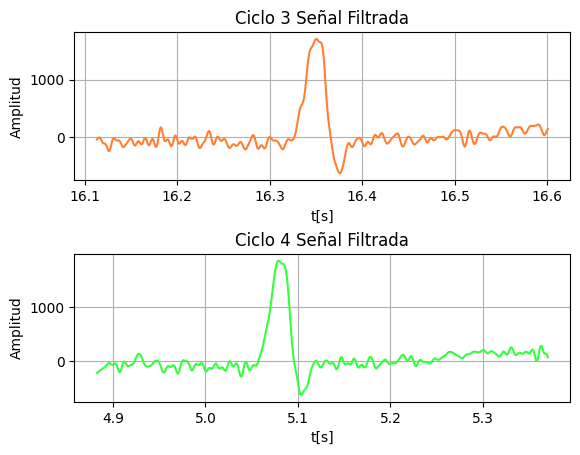

In [159]:
ciclo_ECG_filtrado_3 = ECG_filtrado_1D[16500:17000]
ciclo_ECG_filtrado_4 = ECG_filtrado_1D[5000:5500]

plt.subplots_adjust(hspace=0.5, wspace=0.6)

plt.subplot(2,1,1)
plt.plot(ECG_filtrado_t[16500:17000],ciclo_ECG_filtrado_3, "#ff8033")
plt.title('Ciclo 3 Señal Filtrada')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ECG_filtrado_t[5000:5500],ciclo_ECG_filtrado_4,"#33ff3f")
plt.title('Ciclo 4 Señal Filtrada')
plt.xlabel('t[s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

Después de tener los dos ciclos iniciales, para poder hacer un análisis inferencial a través de la prueba paramétrica T, se debe cumplir los supuestos de normalidad y de homocedasticidas ya que se indicó que las señales son independientes:

Para revisar si los datos provienen de una distribución normal se realiza la prueba de Shapiro, la cual es ideal cuando contamos con pocos datos como en este caso que solo estamos tomando un ciclco del ECG dado. Las hipótesis para esta prueba son:

**Hipótesis Nula (H0)**: los datos siguen una distribución normal

**Hipótesis Alternativa (Ha)**:los datos no siguen una distribución normal

Porteriormente, para poder determinar si se cumple con el supuesto de homocedasticidad, se utiliza la prueba de Leave. Las hipótesis para estas pruebas son:


**Hipótesis Nula (H0)**:  los datos proceden de distribuciones con la misma varianza

**Hipótesis Alternativa (Ha)**: los datos no proceden de distribuciones con la misma varianza

In [160]:
print("CICLO 3")
print("PRUEBA DE NORMALIDAD PARA EL CICLO 3")
# Prueba de normalidad (Shapiro) para el ciclo 1
stat_normalidad_ciclo_3, p_valor_normalidad_ciclo_3 = stats.shapiro(ciclo_ECG_filtrado_3)
print(f'Estadístico de prueba: {stat_normalidad_ciclo_3:.4f}')
print(f'P-valor para el ciclo 3: {p_valor_normalidad_ciclo_3:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_normalidad_ciclo_3 > alfa:
    print('No se rechaza la hipótesis nula. Los datos del ciclo 3 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos del ciclo 3 no siguen una distribución normal.')
print("------------------------------------------------------------------------------------------")
print("CICLO 4")
print("PRUEBA DE NORMALIDAD PARA EL CICLO 4")
# Prueba de normalidad (Shapiro) para el ciclo 2
stat_normalidad_ciclo_4, p_valor_normalidad_ciclo_4 = stats.shapiro(ciclo_ECG_filtrado_4)
print(f'Estadístico de prueba: {stat_normalidad_ciclo_4:.4f}')
print(f'P-valor para el ciclo 4: {p_valor_normalidad_ciclo_4:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_normalidad_ciclo_4 > alfa:
    print('No se rechaza la hipótesis nula. Los datos del ciclo 4 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos del ciclo 4 no siguen una distribución normal.')
print("------------------------------------------------------------------------------------------")
print("PRUEBA DE HOMOCEDASTICIDAD PARA ENTRE EL CICLO 3 Y EL CICLO 4")
stat_homogeneidad_ciclo_34, p_valor_homogeniedad_ciclo_34 = stats.levene(ciclo_ECG_filtrado_3, ciclo_ECG_filtrado_4, center='median')
print(f'Estadístico de prueba: {stat_homogeneidad_ciclo_34:.4f}')
print(f'P-valor para el ciclo 3 y 4: {p_valor_homogeniedad_ciclo_34:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_homogeniedad_ciclo_34 > alfa:
  print('No se rechaza la hipótesis nula. Los datos proceden de distribuciones con la misma varianza.')
else:
  print('Se rechaza la hipótesis nula. Los datos no proceden de distribuciones con la misma varianza.')


CICLO 3
PRUEBA DE NORMALIDAD PARA EL CICLO 3
Estadístico de prueba: 0.5846
P-valor para el ciclo 3: 0.0000
Se rechaza la hipótesis nula. Los datos del ciclo 3 no siguen una distribución normal.
------------------------------------------------------------------------------------------
CICLO 4
PRUEBA DE NORMALIDAD PARA EL CICLO 4
Estadístico de prueba: 0.6036
P-valor para el ciclo 4: 0.0000
Se rechaza la hipótesis nula. Los datos del ciclo 4 no siguen una distribución normal.
------------------------------------------------------------------------------------------
PRUEBA DE HOMOCEDASTICIDAD PARA ENTRE EL CICLO 3 Y EL CICLO 4
Estadístico de prueba: 0.5035
P-valor para el ciclo 3 y 4: 0.4781
No se rechaza la hipótesis nula. Los datos proceden de distribuciones con la misma varianza.


**El valor p en las pruebas de normalidad realizadas anteriormente es menor al
valor del nivel de significancia, por lo tanto se rechaza la hipótesis nula**.

Respecto al supuesto de homocedasticidad, fué el único que si se cumplió, pero debido al peso de las distribuciones normales como requisito para pruebas parétricas, **se decidió utilizar prubeas no paramétricas debido a que no se cumpió el supuesto de normalidad**

Para ello utilizaremos la prueba no paramétrica **U de Mann-Whitney**

In [161]:
stat_no_parametrica_34, p_valor_no_parametrica_34= stats.mannwhitneyu(ciclo_ECG_filtrado_3, ciclo_ECG_filtrado_4, alternative='two-sided')
print(f'Estadístico de prueba: {stat_no_parametrica_34:.4f}')
print(f'P-valor para la prueba no paramétrica: {p_valor_no_parametrica_34:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_no_parametrica_34 < alfa:
    print('Se rechaza la hipótesis nula. Hay evidencia de una diferencia entre los ciclos 3 y 4')
else:
    print('No hay suficiente evidencia para rechazar la hipótesis nula. No se encontró diferencia significativa entre los ciclos 3 y 4.')


Estadístico de prueba: 110309.0000
P-valor para la prueba no paramétrica: 0.0013
Se rechaza la hipótesis nula. Hay evidencia de una diferencia entre los ciclos 3 y 4


**Finalmente, puede concluirse con estos 4 ciclos analizados en diferentes momentos de la señal que la misma no es estacionaria debido a que el análisis inferencial realizado para cada grupo de ciclos nos indicó que si es existe una diferencia estadística significativa que influye en la naturaleza no estacionaria de la señal ECG dada**

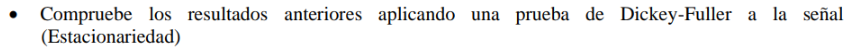

In [126]:
# Prueba de Dickey-Fuller nos permite verificar si una serie de tiempo es estacionaria
ECG_filtrado = ECG_filtrado.flatten() # Señal a unidimensional
prueba = adfuller(ECG_filtrado)

print('Estadística de la prueba:', prueba[0])
print('Valor P:', prueba[1])
print('Valores críticos:', prueba[4])


if prueba[1] < prueba[0]:
    print("La señal es estacionaria")
else:
    print("La señal NO es estacionaria")

Estadística de la prueba: -0.6546593807809804
Valor P: 0.8581469379838581
Valores críticos: {'1%': -3.430563031267381, '5%': -2.8616341541406003, '10%': -2.5668201153621077}
La señal NO es estacionaria


**Ya que el valor estadístico de la prueba de Dickey-Fuller es mayor que los valores críticos que son los más cercanos a cero, no se puede rechazar la hipótesis nula de que los datos de la señal filtrada tiene una raíz unitaria y, por lo tanto, no es estacionaria**. Esto también se justifica en que los valores críticos son negativos y dependen del nivel de significancia. Entre más negativos seán los valores críticos, mayor rechazo de la hipótesis nula.

 Además, el valor P es un valor mucho mayor que la estadística de prueba, confirmando que no hay suficiente evidencia para rechazar la hipótesis nula.
